# ¿Planes heredados o planes nuevos?

La compañía móvil Megaline no está satisfecha al ver que muchos de sus clientes utilizan planes heredados. Quieren desarrollar un modelo que pueda analizar el comportamiento de los clientes y recomendar uno de los nuevos planes de Megaline: Smart o Ultra.

# Contents<a id='back'></a>

* [Introducción](#intro)
* [Inicialización](#inicializacion)
* [Cargando datos](#cargando_datos)
* [Explorando los datos](#explorando_datos_iniciales)
* [Segmentación de datos](#segmentación_de_datos)
* [Calidad de diferentes modelos](#calidad_de_diferentes_modelos)
* [Comprobación la calidad del modelo](#comprueba_la_calidad_del_modelo)
* [Prueba de cordura](#prueba_de_cordura)
* [Conclusión general](#end)

## Introducción <a id='intro'></a>
**Propósito del proyecto**
    
   Crear un modelo que analice el comportamiento de los clientes y así recomendar al cliente el plan Smart o Ultra​.

### Objetivos
1. Investigar la calidad de diferentes modelos cambiando los hiperparámetros,
2. Comprobar la calidad del modelo usando el conjunto de prueba,
3. Realizar una prueba de cordura al modelo.

[Volver a Contenidos](#back)

## Inicialización <a id='inicializacion'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
import seaborn as sns

[Volver a Contenidos](#back)

## Cargando los datos <a id='cargando_datos'></a>

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

[Volver a Contenidos](#back)

## Explorando los datos <a id='explorando_datos_iniciales'></a>

**Descripción de datos**

**Tabla Megaline**
- `сalls` —  número de llamadas,
- `minutes` —  duración total de la llamada en minutos,
- `messages` —  número de mensajes de texto,
- `mb_used` —  tráfico de Internet utilizado en MB,
- `is_ultra` —  plan para el mes actual (Ultra - 1, Smart - 0).

In [3]:
df.shape

(3214, 5)

In [4]:
# Imprimiendo la información general/resumen sobre el DataFrame de los planes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [6]:
# Imprime una muestra de los datos para los planes
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


**Valores ausentes**

In [7]:
df.isna().sum().sort_values(ascending=False)

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

### Conclusión intermedia

 - **`DataFrame Megaline`** — la tabla tiene 5 columnas, 3.214 filas. Sin valores ausentes. Y valores duplicados no se puede corroborar al no tener un ID en el DataFrame.

[Volver a Contenidos](#back)

### **Análisis de correlación**

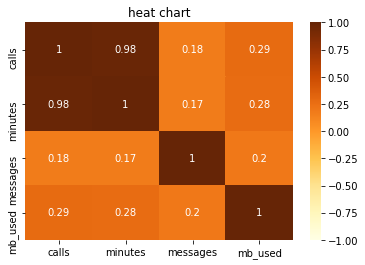

In [8]:
#Matriz de correlación "Gráfico de calor"
factors = ["calls", "minutes", "messages", "mb_used"]
sns.heatmap(df[factors].corr(), annot=True, cmap="YlOrBr", vmax=1, vmin=-1)
plt.title("heat chart")
plt.show()

Las columnas **"calls vs minutes"** (correlación positiva) tienen una *correlación fuerte*.

Las columnas **"calls vs messages"** y **"calls vs mb_used"** (correlación positiva) tienen una *correlación débil*.

## Segmentación de datos <a id='segmentación_de_datos'></a>

Segmentando los datos fuente en un conjunto de entrenamiento, validación y prueba.

In [9]:
#Features excluding 'is_ultra'
features = df.drop(columns=['is_ultra'])

#Target
target = df['is_ultra']

In [10]:
features.shape

(3214, 4)

In [11]:
target.shape

(3214,)

In [12]:
# División de datos en conjuntos de entrenamiento y validación
random_seed = 200

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size = 0.2,
                                                    random_state=random_seed)

X_rtrain, X_valid, y_rtrain, y_valid  = train_test_split(X_train,
                                                        y_train,
                                                        test_size = 0.25,
                                                        random_state=random_seed+1)

In [13]:
for df in [X_train, X_test, X_rtrain, X_valid]:
  print(df.shape)

(2571, 4)
(643, 4)
(1928, 4)
(643, 4)


Vamos a entrenar al modelo con 2.571 observaciones, escoger los hiperparametros con 643 observaciones, entrenar al modelo con 1.928 observaciones y la muestra de prueba final con 643 observaciones.

[Volver a Contenidos](#back)

## Calidad de diferentes modelos <a id='calidad_de_diferentes_modelos'></a>

Investigando la calidad de los diferentes modelos cambiando los hiperparámetros

### Modelo de árbol de decisión

In [14]:
random_seed = 200
i = -1
best_accuracy_score_DT = 0
best_max_depth_DT = 0

for max_depth in [2, 4, 6, 8, 10]:
    model = DecisionTreeClassifier(random_state=random_seed + i,
                                   max_depth=max_depth) # creando el modelo con pseudoaleatoriedad definida y profundidad proporcionada
    model.fit(X_rtrain, y_rtrain) # entrenando el modelo 
    predictions = model.predict(X_valid) # obteniendo la predicción del modelo
    accuracy = accuracy_score(y_valid, predictions) # calculando la exactitud

    if accuracy > best_accuracy_score_DT:
      best_max_depth_DT = max_depth
      best_accuracy_score_DT = accuracy
      best_model_DT = model

print(f"Best max depth DT: {best_max_depth_DT}")
print(f"Best accuracy score DT: {round(best_accuracy_score_DT, 4)}")
print()

Best max depth DT: 6
Best accuracy score DT: 0.7963



**Conclusión intermedia**

- **`Modelo de árbol de decisión`** — el mejor valor para el hiperparametro max_depth es seis y el mejor valor de exactitud es 0.79.

### Modelo de bosque aleatorio

In [15]:
random_seed = 200
i = -1
best_accuracy_score_RF = 0
best_max_depth_RF = 0
best_n_estimators_RF = 0

for max_depth in [5, 6, 7, 8]:
  for n_estimators in [10, 25, 50, 100]:
    model = RandomForestClassifier(random_state=random_seed + i,
                                   n_estimators=n_estimators,
                                   max_depth=max_depth) # creando el modelo con pseudoaleatoriedad definida, profundidad proporcionada y cantidad de árboles
    model.fit(X_rtrain, y_rtrain) # entrenando el modelo 
    predictions = model.predict(X_valid) # obteniendo las predicciones del modelo
    accuracy_ = accuracy_score(y_valid, predictions) # calculando la exactitud

    if accuracy_ > best_accuracy_score_RF:
      best_max_depth_RF = max_depth
      best_n_estimators_RF = n_estimators
      best_accuracy_score_RF = accuracy_
      best_model_RF = model

print(f"Best max depth RF: {best_max_depth_RF}")
print(f"Best n estimators RF: {best_n_estimators_RF}")
print(f"Best accuracy score RF: {round(best_accuracy_score_RF, 4)}")
print()

Best max depth RF: 7
Best n estimators RF: 10
Best accuracy score RF: 0.8149



**Conclusión intermedia**

- **`Modelo de bosque aleatorio`** — el mejor valor para el hiperparametro max_depth es siete, el mejor número de estimadores 10 y el mejor valor de exactitud es 0.81.

### Modelo de regresión logística

In [16]:
random_seed = 200
i = -1
best_accuracy_score_LR = 0
best_penalty = None
solver = "liblinear"

for penalty in ["l1", "l2", "none"]:
    if penalty == "none":
        solver = "saga"
    model = LogisticRegression(random_state=random_seed + i, solver=solver, penalty = penalty, max_iter = 10000) # inicializando el constructor de regresión logística con pseudoaleatoriedad definida, solver='liblinear', penalizadores e iteraciones (max-iter)
    model.fit(X_rtrain, y_rtrain) # entrenando el modelo 
    predictions = model.predict(X_valid) # obteniendo las predicciones del modelo
    accuracy_ = accuracy_score(y_valid, predictions) # calculando la exactitud

    if accuracy_ > best_accuracy_score_LR:
      best_accuracy_score_LR = accuracy_
      best_penalty = penalty
      best_model_LR = model

print(f"Best penalty: {best_penalty}")
print(f"Best accuracy score LR: {round(best_accuracy_score_LR, 4)}")
print()

Best penalty: l1
Best accuracy score LR: 0.7449



**Conclusión intermedia**

- **`Modelo de regresión logística`** — la mejor penalización es l1 y el mejor valor de exactitud es 0.75.

[Volver a Contenidos](#back)

## Comprueba la calidad del modelo <a id='comprueba_la_calidad_del_modelo'></a>

Comprobando la calidad del modelo usando el conjunto de prueba.

### Modelo de árbol de decisión

In [17]:
random_seed = 42

test_preds = best_model_DT.predict(X_test)

test_accuracy_DT = accuracy_score(y_test, test_preds) #Respuestas correctas y predicciones del modelo

print(f"Valid accuracy score: {round(best_accuracy_score_DT, 4)}")
print()
print(f"Test accuracy score: {round(test_accuracy_DT, 4)}")

Valid accuracy score: 0.7963

Test accuracy score: 0.7854


**Conclusión intermedia**

- **`Modelo de árbol de decisión`** — la exactitud entre ambos esta muy a la par; sin embargo, el modelo funciona mejor con el conjunto de entrenamiento.

### Modelo de bosque aleatorio

In [18]:
random_seed = 42

test_preds = best_model_RF.predict(X_test)

test_accuracy_RF = accuracy_score(y_test, test_preds)

print(f"Valid accuracy score: {round(best_accuracy_score_RF, 4)}")
print()
print(f"Test accuracy score: {round(test_accuracy_RF, 4)}")

Valid accuracy score: 0.8149

Test accuracy score: 0.7963


**Conclusión intermedia**

- **`Modelo de bosque aleatorio`** — la exactitud entre ambos esta muy a la par; sin embargo, igual que el modelo de árbol de decisión, el modelo funciona mejor con el conjunto de entrenamiento.

### Modelo de regresión logística

In [19]:
random_seed = 42

test_preds = best_model_LR.predict(X_test)

test_accuracy_LR = accuracy_score(y_test, test_preds)

print(f"Valid accuracy score: {round(best_accuracy_score_LR, 4)}")
print()
print(f"Test accuracy score: {round(test_accuracy_LR, 4)}")

Valid accuracy score: 0.7449

Test accuracy score: 0.7465


**Conclusión intermedia**

- **`Modelo de regresión logística`** — la exactitud entre ambos es similar; el modelo de regresión logistica, funciona bien.

[Volver a Contenidos](#back)

## Prueba de cordura <a id='prueba_de_cordura'></a>

In [20]:
#Creando el modelo
dum_model = DummyClassifier(strategy='most_frequent')

In [21]:
#Entrenando el modelo
dum_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [22]:
#Predicción del modelo
y_dum =  dum_model.predict(X_test)

In [23]:
#Exactitud del modelo
accuracy_score(y_test, y_dum)

0.6749611197511665

In [24]:
test_accuracy_DT

0.7853810264385692

In [25]:
test_accuracy_RF

0.7962674961119751

In [26]:
test_accuracy_LR

0.7465007776049767

Los tres modelos si pasan la prueba de cordura, dummy 67.49%, vs. DT (árbol de decisión) 78.53%, RF (bosque aleatorio ) 79.62% y LR (regresión lineal) 74.65%

[Volver a Contenidos](#back)

## Conclusión general <a id='end'></a>



[Volver a Contenidos](#back)

1. Al conocer la calidad de los diferentes modelos, el modelo con mayor exactitud es el modelo de bosque aleatorio, seguido por el modelo de árbol de decisión y por último el modelo de regresión logística.
2. Comprobando la calidad de los modelos usando el conjunto de prueba, se evidenció que el modelo de árbol de decisión y el de bosque aleatorio se ajustaron para la muestra de validación, pero no tanto para la muestra de prueba. A diferencia del modelo de regresión logística, que si se ajusta bien para ambos casos.
3. Al realizar la prueba de cordura a los modelos, a pesar de lo mencionado en el punto dos, se comparó las métricas de los modelos con la métrica del modelo simple, y los tres modelos pasaron la prueba.

Teniendo como conclusión final, que los tres modelos (el modelo de bosque aleatorio, el modelo de árbol de decisión y el modelo de regresión logística), son buenos modelos.